*Created at: 07/08/2024*

<a href='https://www.dicoding.com/users/mkavaldo/' target="_blank">Dicoding</a> /
<a href='https://www.linkedin.com/in/maulana-kavaldo/' target="_blank">LinkedIn</a> /
<a href='mailto:alkav.maulana@gmail.com' target="_blank">Email</a> /
<a href='https://github.com/maulanakavaldo' target="_blank">Github</a>

---

Nama        : Maulana Kavaldo

IdDicoding  : mkavaldo

## Setup Base Directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
BaseDir = '/content/drive/MyDrive/Colab Notebooks/Klasifikasi-Gambar/'

## Download Library

In [3]:
%%capture
!pip install --upgrade tensorflow
!pip install tensorflowjs
!pip install tensorflow

## Import Library

In [4]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from PIL import Image
import cv2

import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

In [5]:
# build_info = tf.sysconfig.get_build_info()
# print(f"{'CUDA version':20}: {build_info.get('cuda_version', 'Not available')}")
# print(f"{'cuDNN version':20}: {build_info.get('cudnn_version', 'Not available')}")
print(f"{'Numpy Version':20}: {np.__version__}")
print(f"{'Pandas Version':20}: {pd.__version__}")
print(f"{'Tensorflow Version':20}: {tf.__version__}")
print(f"{'TensorflowJS Version':20}: {tfjs.__version__}")
print(f"{'Matplotlib Version':20}: {matplotlib.__version__}")
print(f"{'Scikit-Learn Version':20}: {sklearn.__version__}")

Numpy Version       : 1.26.4
Pandas Version      : 2.2.2
Tensorflow Version  : 2.15.1
TensorflowJS Version: 4.20.0
Matplotlib Version  : 3.7.5
Scikit-Learn Version: 1.2.2


In [ ]:
from google.colab import files
files.upload()

## Data Loading

In [8]:
# %%capture
!unzip fruits.zip

### Merged Dataset

Menggabungkan gambar dari 3 folder yang berbeda.

In [9]:
import os
import shutil

# Define the paths
training_dataset_path = '/content/fruits/Training'
test_dataset_path = '/content/fruits/Test'
validation_dataset_path = '/content/fruits/Validation'
dataset_path = BaseDir+'dataset/fruits'

def copy_contents(src, dst):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            if not os.path.exists(d):
                os.makedirs(d)
            copy_contents(s, d)
        else:
            shutil.copy2(s, d)

# Create the new directory for the merged dataset
os.makedirs(dataset_path, exist_ok=True)

# Copy contents into the new directory
copy_contents(training_dataset_path, dataset_path)
copy_contents(validation_dataset_path, dataset_path)
copy_contents(test_dataset_path, dataset_path)

### Menampilkan kelas yang terdapat pada dataset

In [10]:
# Classes
DIR = BaseDir+'dataset/fruits'

classes = [i for i in os.listdir(DIR) if '.' not in i]
classes

['cucumber_1',
 'pear_3',
 'apple_red_3',
 'apple_golden_1',
 'cabbage_white_1',
 'apple_granny_smith_1',
 'apple_crimson_snow_1',
 'apple_golden_2',
 'carrot_1',
 'apple_braeburn_1',
 'apple_golden_3',
 'apple_red_delicios_1',
 'apple_pink_lady_1',
 'pear_1',
 'zucchini_dark_1',
 'apple_red_2',
 'apple_red_yellow_1',
 'eggplant_long_1',
 'apple_hit_1',
 'cucumber_3',
 'zucchini_1',
 'apple_rotten_1',
 'apple_6',
 'apple_red_1']

In [12]:
# List ekstensi file gambar yang diizinkan
allowed_extensions = ['.png', '.jpg', '.jpeg']

# Inisialisasi list untuk label dan path
label = []
path = []

for dirname, _, filenames in os.walk(DIR):
    for filename in filenames:
        # Jika ekstensi file ada dalam allowed_extensions
        if os.path.splitext(filename)[-1].lower() in allowed_extensions:
            label.append(os.path.split(dirname)[-1])
            path.append(os.path.join(dirname, filename))

# Create df
df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [13]:
df.head()

,path,label
0,/content/drive/MyDrive/Colab Notebooks/Klasifi...,apple_6
1,/content/drive/MyDrive/Colab Notebooks/Klasifi...,apple_6
2,/content/drive/MyDrive/Colab Notebooks/Klasifi...,apple_6
3,/content/drive/MyDrive/Colab Notebooks/Klasifi...,apple_6
4,/content/drive/MyDrive/Colab Notebooks/Klasifi...,apple_6


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12455 entries, 0 to 12454
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    12455 non-null  object
 1   label   12455 non-null  object
dtypes: object(2)
memory usage: 194.7+ KB


Terdapat 12.455 data gambar yang siap digunakan.

✅ Kriteria > 10.000 data gambar terpenuhi

In [15]:
# Check value counts
df['label'].value_counts()

label
apple_hit_1             936
pear_1                  650
apple_granny_smith_1    640
apple_braeburn_1        640
apple_rotten_1          638
apple_crimson_snow_1    636
apple_red_2             636
apple_golden_3          632
apple_6                 630
apple_pink_lady_1       625
apple_red_1             618
apple_red_yellow_1      616
apple_golden_2          616
apple_golden_1          616
apple_red_delicios_1    600
apple_red_3             562
cucumber_3              325
eggplant_long_1         320
zucchini_1              320
zucchini_dark_1         320
pear_3                  287
carrot_1                201
cucumber_1              200
cabbage_white_1         191
Name: count, dtype: int64

In [17]:
# df['label'].unique()

### Cek Resolution

Pada langkah ini, hanya akan menampilkan 5 resolusi gambar yang berbeda. Jika menampilkan semuanya notebook dapat mengalami not responding.

In [18]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            if len(unique_sizes) >= 5:
                break
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in list(unique_sizes)[:5]:  # Menampilkan 5 resolusi unik
            print(f"- {size}")
        print("---------------")
        unique_sizes.clear()

    print(f"\nTotal: {total_images}")

In [19]:
print_images_resolution(DIR)

cucumber_1: 200
- (319, 800)
- (313, 803)
- (337, 800)
- (329, 795)
- (359, 791)
---------------
pear_3: 287
- (623, 747)
- (608, 742)
- (595, 745)
- (607, 739)
- (603, 744)
---------------
apple_red_3: 562
- (571, 563)
- (601, 565)
- (544, 546)
- (539, 557)
- (572, 564)
---------------
apple_golden_1: 616
- (360, 320)
- (363, 322)
- (361, 367)
- (353, 368)
- (360, 368)
---------------
cabbage_white_1: 191
- (736, 705)
- (781, 768)
- (740, 718)
- (766, 726)
- (727, 705)
---------------
apple_granny_smith_1: 640
- (474, 461)
- (445, 462)
- (478, 462)
- (508, 459)
- (469, 462)
---------------
apple_crimson_snow_1: 636
- (585, 569)
- (647, 577)
- (611, 552)
- (572, 532)
- (568, 570)
---------------
apple_golden_2: 616
- (418, 396)
- (425, 395)
- (418, 398)
- (406, 443)
- (411, 440)
---------------
carrot_1: 201
- (205, 633)
- (193, 632)
- (184, 652)
- (182, 630)
- (178, 645)
---------------
apple_braeburn_1: 640
- (474, 393)
- (474, 457)
- (467, 412)
- (471, 458)
- (474, 458)
------------

### Show Images Sample

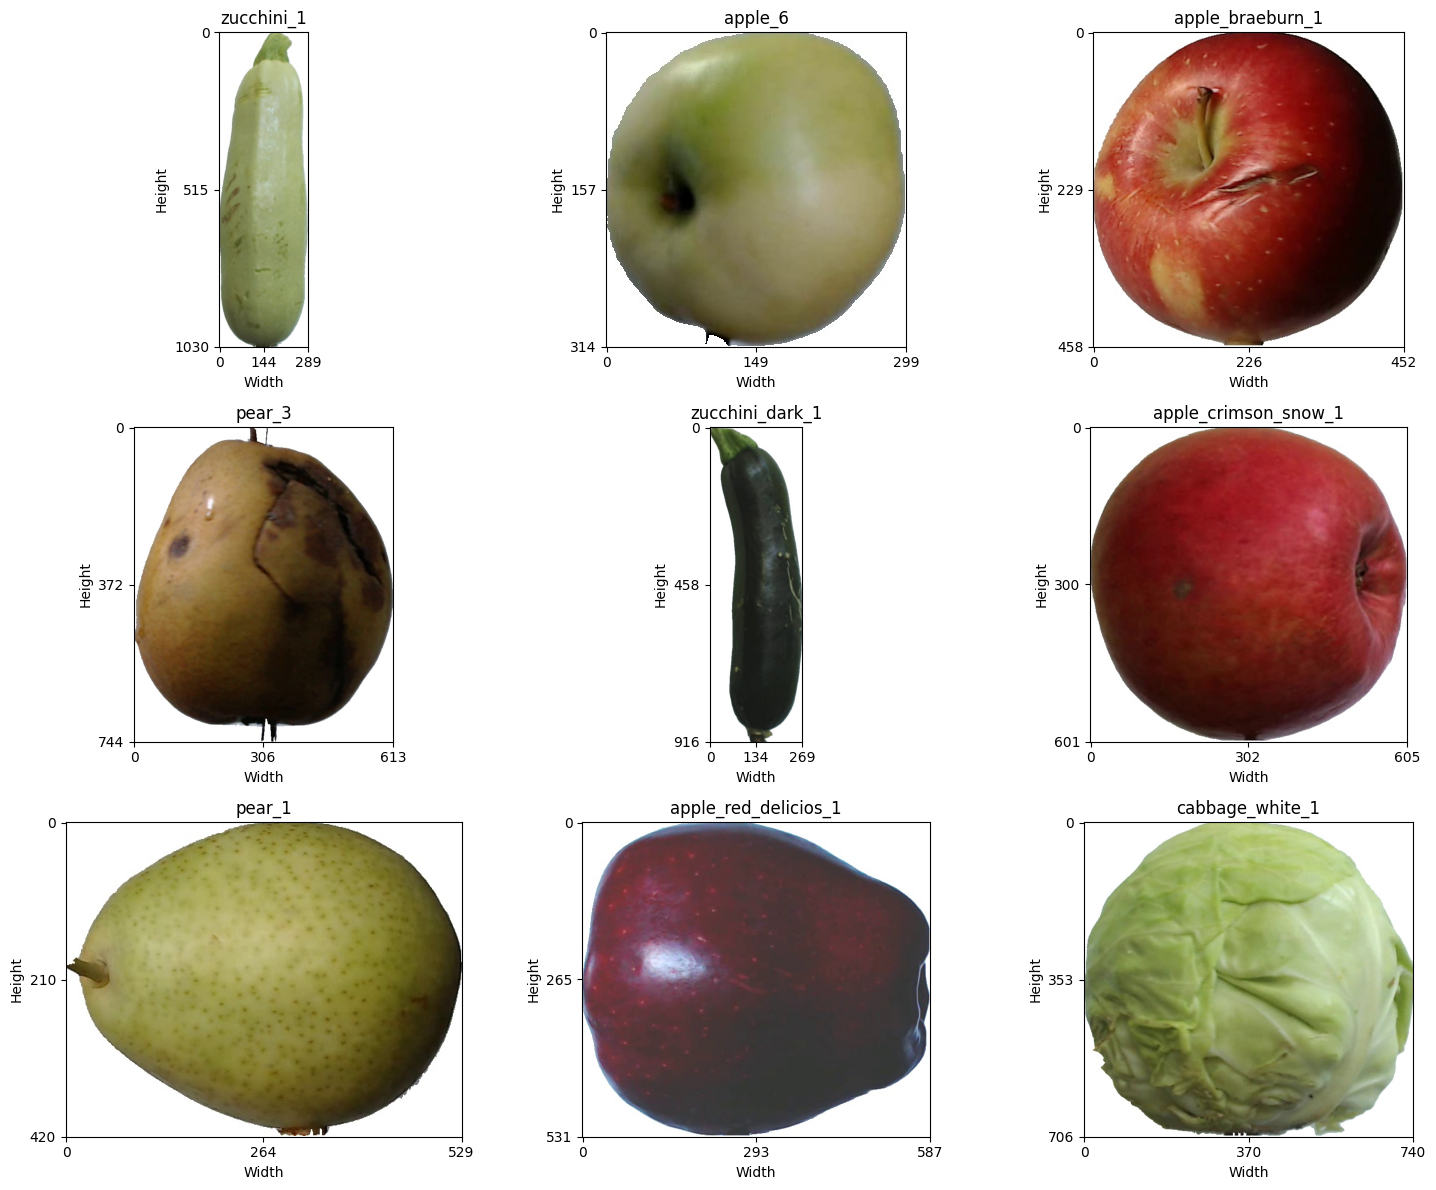

In [20]:
# Mengambil 9 label unik pertama
unique_labels = df['label'].unique()[:9]

plt.figure(figsize=(15,12))
for id, unique_label in enumerate(unique_labels):
    plt.subplot(3, 3, id+1)
    img_path = df[df['label'] == unique_label].iloc[0, 0]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(unique_label)
    
    # Menambahkan skala x dan y berdasarkan ukuran gambar
    height, width = img.shape[:2]
    plt.xticks([0, width//2, width], [0, width//2, width])
    plt.yticks([0, height//2, height], [0, height//2, height])
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.axis('on')

plt.tight_layout()
plt.show()

Terlihat dari gambar yang ditampilkan memiliki resolusi/ ukuran yang berbeda. 

## Split Dataset

In [21]:
# Train Test Split 
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [22]:
# Check shape of df
print(train_df.shape)
print(test_df.shape)

(9964, 2)
(2491, 2)


## Data Preprocessing

In [23]:
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [24]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df, 
    x_col='path', 
    y_col='label', 
    target_size=(224, 224), 
    color_mode='rgb',
#     color_mode='grayscale',
    class_mode='categorical', 
    batch_size=32, 
    shuffle=False, 
    seed=42
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df, 
    x_col='path', 
    y_col='label', 
    target_size=(224, 224), 
    color_mode='rgb', 
#     color_mode='grayscale',
    class_mode='categorical', 
    batch_size=32, 
    shuffle=False 
)

Found 9964 validated image filenames belonging to 24 classes.
Found 2491 validated image filenames belonging to 24 classes.


### Plotting images after pre-processing

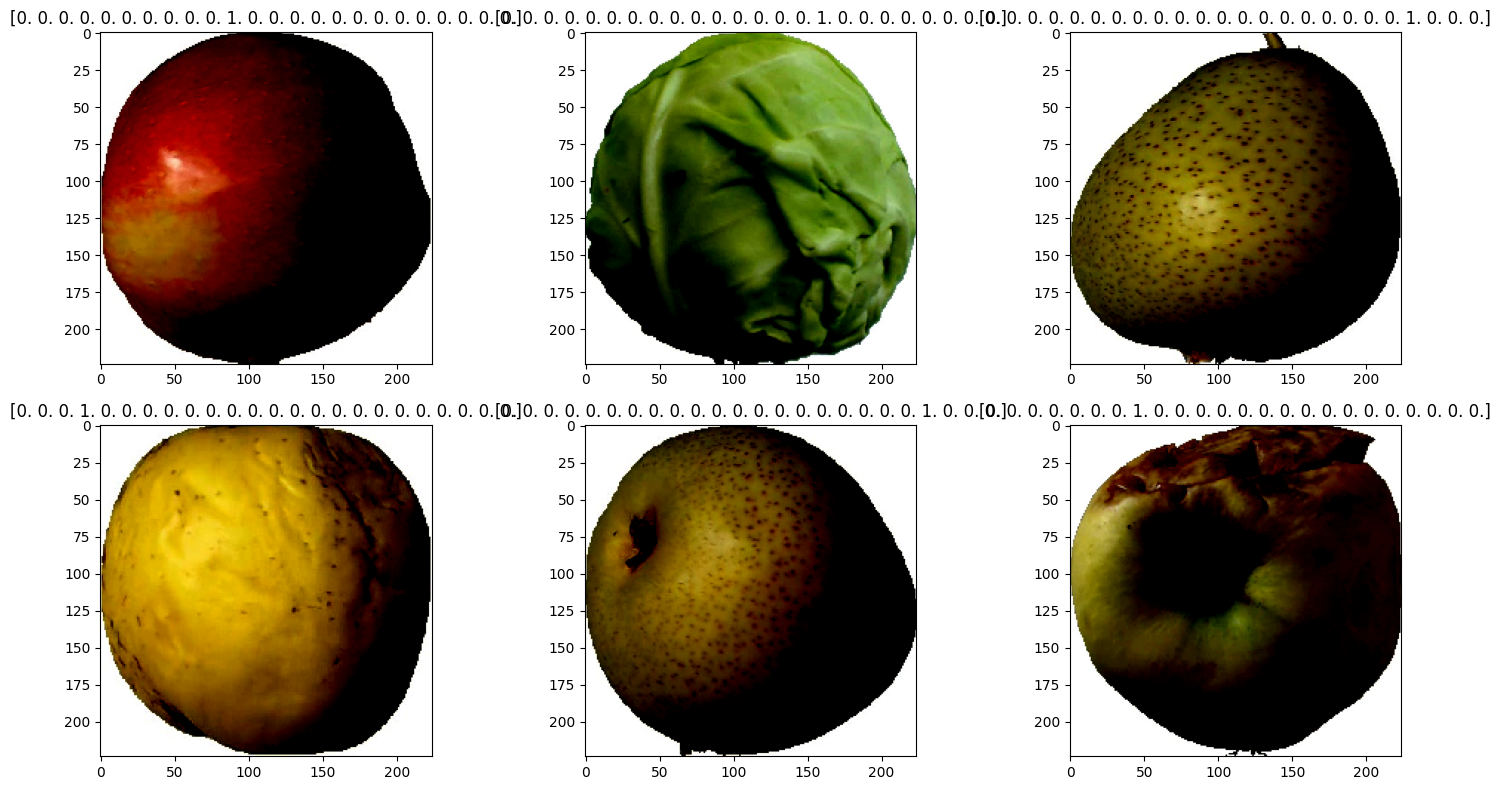

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()

for i in range(6):
    img, label = next(test_images)
    ax[i].imshow(img[0])
    ax[i].set_title(str(label[0]))

plt.tight_layout()
plt.show()

## Modelling

### Sequential

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(24, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)     

In [27]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Train the model
history = model.fit(train_images,
                    validation_data=test_images,
                    epochs=10,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/10
312/312 [==============================] - 44s 122ms/step - loss: 0.2747 - accuracy: 0.9386 - val_loss: 0.6819 - val_accuracy: 0.7896 - lr: 0.0010
Epoch 2/10
312/312 [==============================] - 31s 101ms/step - loss: 0.0167 - accuracy: 0.9993 - val_loss: 0.0036 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
312/312 [==============================] - 32s 102ms/step - loss: 0.0319 - accuracy: 0.9940 - val_loss: 0.0105 - val_accuracy: 0.9972 - lr: 0.0010
Epoch 4/10
312/312 [==============================] - 32s 102ms/step - loss: 0.0063 - accuracy: 0.9997 - val_loss: 4.3834e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
312/312 [==============================] - 32s 104ms/step - loss: 0.0037 - accuracy: 0.9997 - val_loss: 0.0040 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 6/10
312/312 [==============================] - 32s 101ms/step - loss: 0.0031 - accuracy: 0.9999 - val_loss: 2.8158e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
312/312 [========================

### Plot Accuracy and Validation

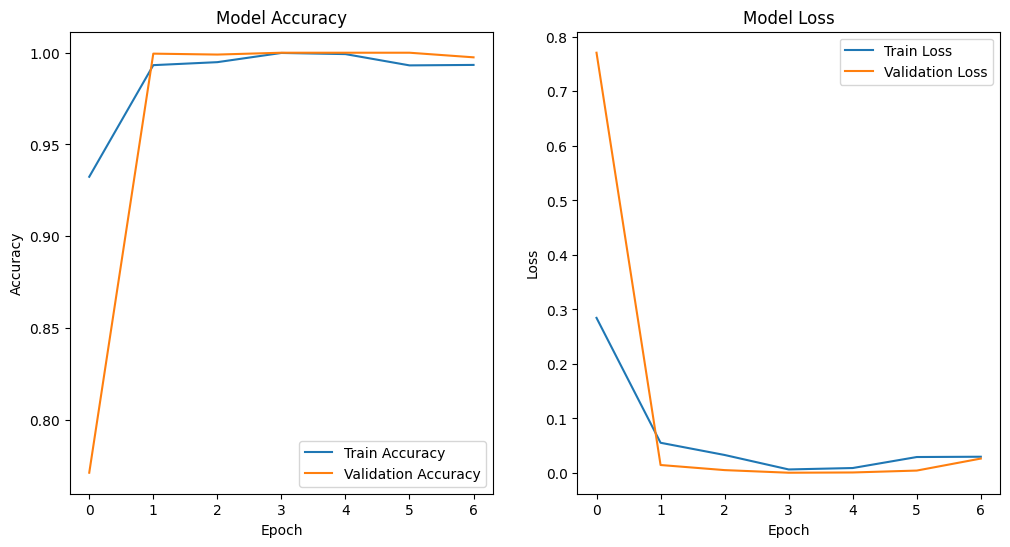

In [28]:
# Plotting Akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

#### Test Accuracy

In [29]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.00002
Test Accuracy: 100.00%


## MobileNetV2

In [30]:
# Load pretrained MobileNetV2 model without the top layers
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
pretrained_model.trainable = False

# Create a new Sequential model
model2 = models.Sequential()

# Add the pretrained model
model2.add(pretrained_model)

# Add Conv2D layer
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Add Pooling layer
model2.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from the pretrained model
model2.add(layers.Flatten())

# Add Dense layers
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))

# Add the output layer
model2.add(layers.Dense(24, activation='softmax'))

# Display the model summary
model2.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                           

In [31]:
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

history = model2.fit(train_images,
                     validation_data=test_images,
                     epochs=5,
                     callbacks=[early_stopping, reduce_lr]
                   )

Epoch 1/5
312/312 [==============================] - 38s 110ms/step - loss: 0.0302 - accuracy: 0.9909 - val_loss: 1.3443e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/5
312/312 [==============================] - 33s 104ms/step - loss: 4.8600e-05 - accuracy: 1.0000 - val_loss: 4.0772e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/5
312/312 [==============================] - 32s 103ms/step - loss: 1.9244e-05 - accuracy: 1.0000 - val_loss: 2.1851e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/5
312/312 [==============================] - 33s 104ms/step - loss: 9.1450e-06 - accuracy: 1.0000 - val_loss: 1.0300e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/5
312/312 [==============================] - 32s 102ms/step - loss: 4.1812e-06 - accuracy: 1.0000 - val_loss: 5.3353e-06 - val_accuracy: 1.0000 - lr: 0.0010


### Plot Accuracy and Validation

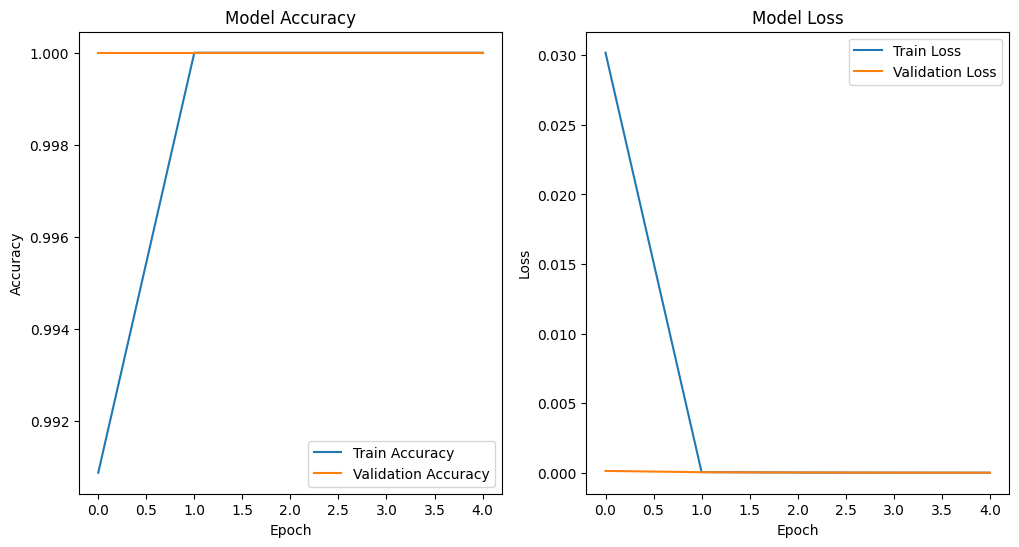

In [32]:
# Plotting Akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

## Save Model

### Saved Model

In [33]:
os.makedirs(BaseDir+'saved_model', exist_ok=True)

tf.saved_model.save(model, 'saved_model')

### TFLITE

In [34]:
# Convert the model to TF-Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF-Lite model to a specific folder
os.makedirs(BaseDir+'tf_lite', exist_ok=True)
folder_path = BaseDir+'tf_lite'
file_path = f'{folder_path}/model.tflite'

with open(file_path, 'wb') as f:
    f.write(tflite_model)

In [35]:
def recreate_labels():
    labels = [folder for folder in os.listdir(DIR) if not folder.startswith('.')]

    with open(BaseDir+'tf_lite/labels.txt', 'w') as file:
        for label in labels:
            file.write(label)
            file.write('\n')

recreate_labels()

### TFJS

In [36]:
import tensorflowjs as tfjs

os.makedirs(BaseDir+'tfjs_model', exist_ok=True)
tfjs.converters.save_keras_model(model, BaseDir+'tfjs_model')

## Inference

In [37]:
interpreter = tf.lite.Interpreter(model_path=BaseDir+'tf_lite/model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load labels
with open(BaseDir+'tf_lite/labels.txt', 'r') as f:
    labels = [line.strip() for line in f.readlines()]

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

In [38]:
image_path = BaseDir+'dataset/fruits/cucumber_1/r0_49.jpg'
input_data = preprocess_image(image_path)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class_idx = np.argmax(output_data, axis=1)[0]
predicted_class = labels[predicted_class_idx]
print('Predicted Class:', predicted_class)

Predicted Class: cucumber_1


In [39]:
image_path = BaseDir+'dataset/fruits/pear_1/r1_292.jpg'
input_data = preprocess_image(image_path)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class_idx = np.argmax(output_data, axis=1)[0]
predicted_class = labels[predicted_class_idx]
print('Predicted Class:', predicted_class)

Predicted Class: pear_1


## Conclusion

- Berdasarkan percobaan, dihasilkan untuk:
    - Model 1
        - Model              : Sequential
        - Akurasi            : 100 %
        - Validasi akurasi   : 100 %
    - Model 2
        - Model              : Sequential dengan pretrained MobileNetV2
        - Akurasi            : 100 %
        - Validasi akurasi   : 100 %

   Sehingga model tersebut dapat digunakan untuk memprediksi gambar buah (_fruits_) dimasa mendatang.
- Hasil model mampu memprediksi gambar buah (fruits) yang diinputkan melalui inference.